# CE811 Tabular REINFORCE Example

M. Fairbank, University of Essex, December 2021

- In this lab we use a table of action probabilities (one row for each cell of a maze) with the REINFORCE algorithm to solve a maze.

- REINFORCE is a policy-gradient algorithm.  Unlike Q-learning, it requires completed trajectories to work, so we force a trajectory-cutoff after 200 time steps.  

- For this reason, we also require a smaller simpler maze to get this algorithm to work in a reasonable time.

- In this notebook, there are just two "TODO" parts for you to complete.  Do these, and read through all of the code the code, run it, plot the graph; and try to understand it!

Acknowledgements: This maze environment is based on one initially built by M. Pisheh (University of Essex)

## First build a maze environment (as in previous example):
- The maze is simply a numpy array.  0s represent walkable areas.  1s represent solid walls.
- The environment_step function is the function that executes an agent's action (i.e north/south/east/west) 
- It calculates the new state (y,x) and the instantaneous reward (-1 each step).
- Note that throughout this notebook, states are y,x not x,y!

In [16]:
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

maze=np.array([
        [1,1,1,1,1,1,1],
        [1,0,1,0,0,0,1],
        [1,0,1,1,1,0,1],
        [1,0,0,0,0,0,1],
        [1,1,1,0,1,0,1],
        [1,0,0,0,1,0,1],
        [1,1,1,1,1,1,1]])

print(maze[0,0])
print(maze[6,6])
print(maze[0])
print("")

maze_width=maze.shape[1]
maze_height=maze.shape[0]
start_state = [1,1] # top left corner zero
goal_state = [maze_height-2,maze_width-2] # bottom-right corner zero

action_names=["North","South","West","East"]
action_effects=[[-1,0],[1,0],[0,-1],[0,1]]


zero_indices = np.where(maze == 0)
print(zero_indices)
print(type(zero_indices))
end_index = np.intersect1d(np.where(zero_indices[0] == goal_state[0]), np.where(zero_indices[1] == goal_state[1]))[0]
zero_indices = list((zero_indices[0][i], zero_indices[1][i]) for i in range(0, len(zero_indices[0])) if i != end_index)

#(np.delete(zero_indices[0], end_index), np.delete(zero_indices[1], end_index))
print(zero_indices)

def get_random_maze_item():
    return zero_indices[np.random.randint(0, len(zero_indices))]

print(get_random_maze_item())

def environment_step(action,state):
    y,x = state
    dy,dx=action_effects[action]
    new_x = x+dx
    new_y = y+dy
    if new_x <0 or new_x>=maze_width:
        # off grid
        new_x = x
    if new_y <0 or new_y>=maze_height:
        # off grid
        new_y = y
    if maze[new_y,new_x]:
        # hit wall
        new_y=y
        new_x=x
    new_state = [new_y,new_x]
    reward = -1
    done = (new_state==goal_state)
    return new_state, reward, done

print("maze",maze)
print("start",start_state)
print("goal",goal_state)
    

1
1
[1 1 1 1 1 1 1]

(array([1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5], dtype=int64), array([1, 3, 4, 5, 1, 5, 1, 2, 3, 4, 5, 3, 5, 1, 2, 3, 5], dtype=int64))
<class 'tuple'>
[(1, 1), (1, 3), (1, 4), (1, 5), (2, 1), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3)]
(5, 3)
maze [[1 1 1 1 1 1 1]
 [1 0 1 0 0 0 1]
 [1 0 1 1 1 0 1]
 [1 0 0 0 0 0 1]
 [1 1 1 0 1 0 1]
 [1 0 0 0 1 0 1]
 [1 1 1 1 1 1 1]]
start [1, 1]
goal [5, 5]


## Next build our table of Probabilities for action in each maze cell. 
- There are 4 potential actions from each maze cell, therefore we need 4 probabilities for each maze cell.
- Since the maze itself is shape [maze_height, maze_width], therefore we need an array of shape [maze_height, maze_width, 4]
- Since in this table, every number is a completely free parameter, hence each row probably will not add up to 1 like probabilities do.  Hence we will need to remember to always use it in conjunction with softmax.


In [17]:
# Create our table of action probabilities.  We need 4 probabilities for every cell in the maze. 
table_action_probabilities_before_softmax=tf.Variable(np.zeros((maze_height,maze_width,len(action_names)),np.float32),tf.float32)
print(table_action_probabilities_before_softmax.shape)

(7, 7, 4)


## Next define a stochastic policy function
- The policy gets probabilities directly from the table and the softmax function.
- Once the 4 probabilities are known, it samples one of them at random.


**TODO: Finish the *run_stochastic_policy* function below.**  
- It needs to choose an action randomly, given the corresponding numpy array of probabilities.
- So for example, if the array of probabilities is [0.1,0.3,0.2,0.4] then it needs to return 0 with probability 0.1, or return 1 with probability 0.3, or return 2 with probability 0.2, or return 3 with probability 0.4.

In [18]:
def get_action_probabilities(state, pre_sm_probs=None):
    y=state[0]
    x=state[1]
    if pre_sm_probs is None:
        pre_sm_probs = table_action_probabilities_before_softmax
    # We can't just use a value straight from the table, because it might not be a valid probability between 0 and 1.
    # Hence we still need to put all 4 probabilities through a softmax function to ensure they are all 
    # positive and sum to 1....
    return tf.nn.softmax(pre_sm_probs[y,x,:])

def run_stochastic_policy(current_state, table=None):
    # Choose an action for current_state 
    #probabilities=get_action_probabilities(current_state).numpy() # The .numpy() here converts from tensorflow tensor to a numpy array
    #action_chosen = np.random.choice([0,1,2,3], 1, probabilities)
    # TODO write code here to set action_chosen to be 0,1,2 or 3, chosen randomly with probabilities given by the probabilities array.
    #return action_chosen
    return np.random.choice([0,1,2,3], 1, p=get_action_probabilities(current_state, table).numpy())[0]


## Next Define the REINFORCE update
- Remember for REINFORCE, the update is $\Delta \theta=\eta \left(\sum_t \frac{dlog(P_t)}{d\theta}\right) (R-b)$ where $P_t$ is the probability assigned to the action that was actually chosen at time step $t$, (i.e. $P_t= p(a_t)$). We saw the proof in the lecture that $\mathbb{E}(\Delta \theta)=\eta \frac{d\mathbb{E}(R)}{d\theta}$, i.e. that the expectation (average) of the REINFORCE update gives us gradient ascent on the expectation of total trajectory reward $R$.

To work out $P_t$ for each trajectory step, we can use the following two lines of code:

```
trajectory_action_probabilities=get_action_probabilities_for_trajectory(trajectory) # this returns a tensor of shape [trajectory_length,4]
chosen_probabilities=tf.gather(trajectory_action_probabilities, indices=action_choices, axis=1, batch_dims=1) # this returns a tensor of shape [trajectory_length]
```

This code is already given to you in the code block below.  When this code is run, it will create an array *chosen_probabilities* of shape [trajectory_length], and the array's content will be [$P_0$,$P_1$,...,$P_n$].  If you want more detail then see the help on [tf.gather](https://www.tensorflow.org/api_docs/python/tf/gather) to understand this more.

- To compute the derivative used by REINFORCE, we will use auto-differentiation, because, remember our probabilities came from a softmax function,  and differentiating by hand through the softmax function might be beyond the scope of this course.  So we'll let tensorflow do the hard work for us!...
- To calculate $\left(\sum_t \frac{dlog(P_t)}{d\theta}\right) (R-b)$, we will first simplify things a little, by writing,
\begin{align}&\left(\sum_t \frac{dlog(P_t)}{d\theta}\right) (R-b)\\=&\frac{d}{d\theta}\left[\left(\sum_t log(P_t)\right)(R-b)\right]\\
=&\frac{dL}{d\theta}\end{align}
where we define:  \begin{align}L=\left(\sum_t log(P_t)\right)(R-b)\end{align}
- Now we can let tensorflow just differentiate $L$, to obtain the gradient $\frac{dL}{d\theta}$.  This will enable us to do the weight update $\Delta \theta = \eta \frac{dL}{d\theta}$.
- Here $\theta$ is our "parameter vector", by which we mean the learnable quantities.  So this is the variable *table_action_probabilities_before_softmax* in our case. 
- Hence we need to set up a gradient tape, and within it define $L=\left(\sum_t log(P_t)\right)(R-b)$, and then use the gradient tape to compute $\frac{dL}{d\theta}$ for us, where $\theta$ means table_action_probabilities_before_softmax.  You need to complete the following code to do that.  You will need to use the tensorflow functions tf.math.log and tf.reduce_sum in here, and the multiplication and subraction operations.  You will also need to use the variables chosen_probabilities, total_reward, and baseline.

**TODO: finish the GradientTape code block below...**

In [19]:
def get_action_probabilities_for_trajectory(trajectory, table=None):
    # On entry, trajectory is a tensor of shape [trajectory_length,2]
    # This returns a tensor of shape [trajectory_length,4]
    # Each row of this tensor is an array of 4 probabilities applicable to timestep t
    trajectory_length=len(trajectory)
    # (These next 2 line could be made much more efficient by operating on whole trajectory at once!...)
    trajectory_action_probabilities=[get_action_probabilities(trajectory[t,:], table) for t in range(trajectory_length)]
    return tf.stack(trajectory_action_probabilities) # converts the list to a tensor

def calculate_reinforce_gradient(trajectory, total_reward, baseline, action_choices, table=None):
    # This function is meant to calculate (dL/d Theta), where L=(\sum_t (log(P_t))(R-b).
    # You need to use the functions tf.math.log and tf.reduce_sum in here, plus the multiplication and subtraction operations.  
    if table is None:
        table = table_action_probabilities_before_softmax
    with tf.GradientTape() as tape:
        tape.watch(table)
        trajectory_action_probabilities=get_action_probabilities_for_trajectory(trajectory, table) # this returns a tensor of shape [trajectory_length,4]
        chosen_probabilities=tf.gather(trajectory_action_probabilities, indices=action_choices, axis=1, batch_dims=1) # this returns a tensor of shape [trajectory_length]
        L = tf.reduce_sum(tf.math.log(chosen_probabilities)) * (total_reward - baseline)
        #L=0 # TODO fix this line of code!
    assert len(L.shape)==0 # checking the original large array has gone through a reduce_sum
    grads = tape.gradient(L, table) # This calculates the gradient required by REINFORCE
    # This function doesn't actually do the update.  It just calculates the gradient ascent direction, and returns it!
    return grads

## Define the main trajectory unroll loop, and learning algorithm:

In [20]:
iterations = 1000
discount_factor=0.95
reward_history=[]
trajectory_length_history=[]

optimizer=keras.optimizers.Adam(0.02)
for iteration in range(iterations):
    state=start_state
    total_reward=0
    done=False
    time_step=0
    trajectory=[]
    step_rewards=[]
    action_choices=[]
    while not done:
        action = run_stochastic_policy(state, table_action_probabilities_before_softmax)
        trajectory.append(np.array(state, np.int32))
        #print("time_step",time_step,"state",state,"action",action)
        next_state, reward, done = environment_step(action, state)
        step_rewards.append(reward)
        action_choices.append(action)

        state = next_state
        total_reward += reward*(discount_factor**time_step)
        time_step+=1
        if time_step>200:
            # break trajectory.  This maze is currently too difficult for REINFORCE to complete a trajectory.
            done=True
            
    trajectory_length=time_step
    #  The next line is a bit of a hack which speeds up learning a lot.
    #  This is a much smoother reward function curve.  It is a function which gets higher the smaller 
    # the trajectory length is. See e.g. https://www.wolframalpha.com/input/?i=plot+y%3D0.95%5Ex+from+x%3D0+to+x%3D200 for the graph
    total_reward=(discount_factor**(trajectory_length-1)) # This works pretty well

    trajectory=np.stack(trajectory,axis=0) # np.stack converts a list into a numpy array of shape [trajectory_shape,2]
    action_choices=np.stack(action_choices,axis=0) # np.stack converts a list into a numpy array of shape [trajectory_shape]
    baseline=0
    grads=calculate_reinforce_gradient(trajectory, total_reward, baseline, action_choices, table_action_probabilities_before_softmax)
    optimizer.apply_gradients(zip([-grads], [table_action_probabilities_before_softmax])) # This updates the parameter vector.  Note the minus sign here (because tensorflow optimize functions assume you only ever want graident DESCENT, but we want ascent here) 
    
    trajectory_length_history.append(trajectory_length)
    reward_history.append(total_reward)
    print("Iteration",iteration,"total_reward",total_reward, "trajectory_length",trajectory_length)


Iteration 0 total_reward 3.50526662488287e-05 trajectory_length 201
Iteration 1 total_reward 0.0033675975668514537 trajectory_length 112
Iteration 2 total_reward 7.187710616690214e-05 trajectory_length 187
Iteration 3 total_reward 3.50526662488287e-05 trajectory_length 201
Iteration 4 total_reward 0.0156896056657629 trajectory_length 82
Iteration 5 total_reward 0.00027275759107716263 trajectory_length 161
Iteration 6 total_reward 3.50526662488287e-05 trajectory_length 201
Iteration 7 total_reward 3.50526662488287e-05 trajectory_length 201
Iteration 8 total_reward 0.37735360253530725 trajectory_length 20
Iteration 9 total_reward 3.50526662488287e-05 trajectory_length 201
Iteration 10 total_reward 0.10467395472325501 trajectory_length 45
Iteration 11 total_reward 3.50526662488287e-05 trajectory_length 201
Iteration 12 total_reward 0.00031813102910297435 trajectory_length 158
Iteration 13 total_reward 8.383391884169954e-05 trajectory_length 184
Iteration 14 total_reward 0.009393946474176 

## Plot graphs
- Should show performance improving over time....
- This maze is theoretically solvable in 8 steps


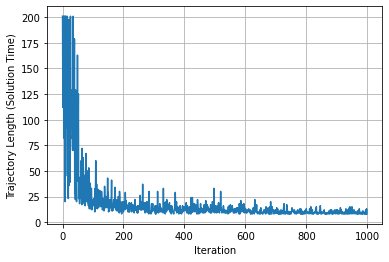

In [21]:
import matplotlib.pyplot as plt
plt.plot(trajectory_length_history)
plt.ylabel('Trajectory Length (Solution Time)')
plt.xlabel('Iteration')
plt.grid()
plt.show()

## A bit more theory (Optional section)

When you see other people's implementations of REINFORCE, e.g. see Andrei Karpathy's [Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/), they often use the cross-entropy error function.  This is because it turns out that cross entropy loss function is very similar to what we need for REINFORCE (since they both have a log in them).

Remember, the cross-entropy loss is defined to be:
\begin{align}
L&=-\sum_t log(P(y_t))\\
\end{align}
where $P(y_t)$ means the probability that the neural network output gives to the true category $y_t$, and $t$ denotes the pattern index for each pattern in the training batch.

With REINFORCE, in our code above, we did gradient ascent on L, where \begin{align}
L=(R-b) \left[\sum_t log(P(a_t))\right]\end{align}

Hence the REINFORCE $L$ term looks almost the same as the Cross-Entropy loss.  They are the same apart from the REINFORCE experssion has an extra multiplication by $-(R-b)$.  As most neural-network training libraries come with gradient calculators for Cross-Entropy, we can use that code to do REINFORCE updates.  The trick is to replace the "true data label" $y_t$ for each pattern number $t$, which the cross-entropy function receives, with the action which your policy chose, i.e. you just need to replace $y_t$ by $a_t$, where $a_t$ is the actual action your policy chose at time-step $t$.  

So we should be able to replace the code we wrote for $L$ by $L=-(R-b)\times $cross_entropy(y_true=action_choices, y_pred=trajectory_action_probabilities), where cross_entropy=tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM).  If you want to try this in your submission to the auto-marker then do so.  Also, it means you can shorten the code quite a bit, and delete that awkward tf.gather line of code.

## Further experimentation ideas? (Optional section)

- To get this method working on the larger maze (from the Q-learning example) we can use a discount factor = 0.98, and also use a baseline.  I found the baseline b=pow(0.98,200) worked, as this meant that trajectories which fail don't cause any learning to happen.  Only the trajectories that solve the maze cause learning to happen (and they teach it how to solve the maze correctly, which is what we want!)

To add more sophisticated functionality:

- We could add a GUI to show the 4 probabilities for each maze cell changing over time.
- We could try to set the baseline intelligently.  You could set it as the average reward obtained from the previous 20 trajecties, and update your baseline using this recipee after every new trajectory finishes.
- We could employ "exploring starts", to try to be able to solve large mazes.  Instead of starting from location (1,1) each trajetory, we start from a random valid location in the maze.
- We could add mini-batching - group together N trajectories and find the average of their weight update, and apply that average all at once.  This should reduce the variance of the REINFORCE weight update, meaning we could use a higher learning rate.
- We could try different reward functions, maybe one that uses a euclidean heuristic for all failed trajectories.
- For the sake of improving your understanding, you could try doing the automatic differentiation by a hand calculation?
- You could replace the table of probabilities by a keras-model (neural network)


If you take any of this further, for your own interest, then please email me with what you come up with!  m.fairbank@essex.ac.uk


## Updating Baseline Trajectories

In [22]:

table_action_probabilities_before_softmax1=tf.Variable(np.zeros((maze_height,maze_width,len(action_names)),np.float32),tf.float32)

iterations1 = 1000
discount_factor1=0.95
reward_history1=[]
trajectory_length_history1=[]

optimizer1=keras.optimizers.Adam(0.02)
for iteration in range(iterations1):
    state=start_state
    total_reward=0
    done=False
    time_step=0
    trajectory=[]
    step_rewards=[]
    action_choices=[]
    while not done:
        action = run_stochastic_policy(state, table_action_probabilities_before_softmax1)
        trajectory.append(np.array(state, np.int32))
        #print("time_step",time_step,"state",state,"action",action)
        next_state, reward, done = environment_step(action, state)
        step_rewards.append(reward)
        action_choices.append(action)

        state = next_state
        total_reward += reward*(discount_factor1**time_step)
        time_step+=1
        if time_step>200:
            # break trajectory.  This maze is currently too difficult for REINFORCE to complete a trajectory.
            done=True

    trajectory_length=time_step
    #  The next line is a bit of a hack which speeds up learning a lot.
    #  This is a much smoother reward function curve.  It is a function which gets higher the smaller
    # the trajectory length is. See e.g. https://www.wolframalpha.com/input/?i=plot+y%3D0.95%5Ex+from+x%3D0+to+x%3D200 for the graph
    total_reward=(discount_factor**(trajectory_length-1)) # This works pretty well

    trajectory=np.stack(trajectory,axis=0) # np.stack converts a list into a numpy array of shape [trajectory_shape,2]
    action_choices=np.stack(action_choices,axis=0) # np.stack converts a list into a numpy array of shape [trajectory_shape]
    baseline=0
    if iteration >= 20:
        baseline = sum(reward_history1[iteration-20:iteration-1])/20
    grads=calculate_reinforce_gradient(trajectory, total_reward, baseline, action_choices, table_action_probabilities_before_softmax1)
    optimizer1.apply_gradients(zip([-grads], [table_action_probabilities_before_softmax1])) # This updates the parameter vector.  Note the minus sign here (because tensorflow optimize functions assume you only ever want graident DESCENT, but we want ascent here)

    trajectory_length_history1.append(trajectory_length)
    reward_history1.append(total_reward)
    print("Iteration",iteration,"total_reward",total_reward, "trajectory_length",trajectory_length, "baseline", baseline)


Iteration 0 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 1 total_reward 0.03949909390643792 trajectory_length 64 baseline 0
Iteration 2 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 3 total_reward 0.0026057828024010363 trajectory_length 117 baseline 0
Iteration 4 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 5 total_reward 0.00047953155208806027 trajectory_length 150 baseline 0
Iteration 6 total_reward 0.09446824413773763 trajectory_length 47 baseline 0
Iteration 7 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 8 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 9 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 10 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 11 total_reward 0.030563645913324063 trajectory_length 69 baseline 0
Iteration 12 total_reward 3.50526662488287e-05 traje

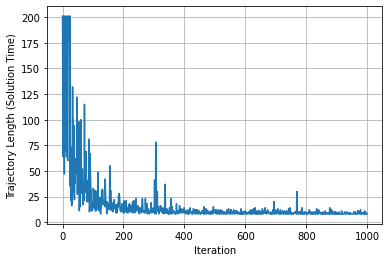

In [23]:
plt.plot(trajectory_length_history1)
plt.ylabel('Trajectory Length (Solution Time)')
plt.xlabel('Iteration')
plt.grid()
plt.show()

## Random exploring starts

In [24]:
table_action_probabilities_before_softmax2=tf.Variable(np.zeros((maze_height,maze_width,len(action_names)),np.float32),tf.float32)

iterations2 = 1000
discount_factor2=0.95
reward_history2=[]
trajectory_length_history2=[]

optimizer2=keras.optimizers.Adam(0.02)
for iteration in range(iterations2):
    state=get_random_maze_item()
    if iteration == iterations2-1 or iteration == 0:
        state = start_state
    total_reward=0
    done=False
    time_step=0
    trajectory=[]
    step_rewards=[]
    action_choices=[]
    while not done:
        action = run_stochastic_policy(state, table_action_probabilities_before_softmax2)
        trajectory.append(np.array(state, np.int32))
        #print("time_step",time_step,"state",state,"action",action)
        next_state, reward, done = environment_step(action, state)
        step_rewards.append(reward)
        action_choices.append(action)

        state = next_state
        total_reward += reward*(discount_factor2**time_step)
        time_step+=1
        if time_step>200:
            # break trajectory.  This maze is currently too difficult for REINFORCE to complete a trajectory.
            done=True

    trajectory_length=time_step
    #  The next line is a bit of a hack which speeds up learning a lot.
    #  This is a much smoother reward function curve.  It is a function which gets higher the smaller
    # the trajectory length is. See e.g. https://www.wolframalpha.com/input/?i=plot+y%3D0.95%5Ex+from+x%3D0+to+x%3D200 for the graph
    total_reward=(discount_factor2**(trajectory_length-1)) # This works pretty well

    trajectory=np.stack(trajectory,axis=0) # np.stack converts a list into a numpy array of shape [trajectory_shape,2]
    action_choices=np.stack(action_choices,axis=0) # np.stack converts a list into a numpy array of shape [trajectory_shape]
    baseline=0
    if iteration >= 20:
        baseline = sum(reward_history2[iteration-20:iteration-1])/20
    grads=calculate_reinforce_gradient(trajectory, total_reward, baseline, action_choices, table_action_probabilities_before_softmax2)
    optimizer2.apply_gradients(zip([-grads], [table_action_probabilities_before_softmax2])) # This updates the parameter vector.  Note the minus sign here (because tensorflow optimize functions assume you only ever want graident DESCENT, but we want ascent here)

    trajectory_length_history2.append(trajectory_length)
    reward_history2.append(total_reward)
    print("Iteration",iteration,"total_reward",total_reward, "trajectory_length",trajectory_length, "baseline", baseline)


Iteration 0 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 1 total_reward 0.95 trajectory_length 2 baseline 0
Iteration 2 total_reward 0.0001809529587097769 trajectory_length 169 baseline 0
Iteration 3 total_reward 0.0001400179500338499 trajectory_length 174 baseline 0
Iteration 4 total_reward 1.0 trajectory_length 1 baseline 0
Iteration 5 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 6 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 7 total_reward 0.6634204312890623 trajectory_length 9 baseline 0
Iteration 8 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 9 total_reward 0.08974483193085075 trajectory_length 48 baseline 0
Iteration 10 total_reward 0.02903546361765786 trajectory_length 70 baseline 0
Iteration 11 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 12 total_reward 3.50526662488287e-05 trajectory_length 201 baseline 0
Iteration 13 

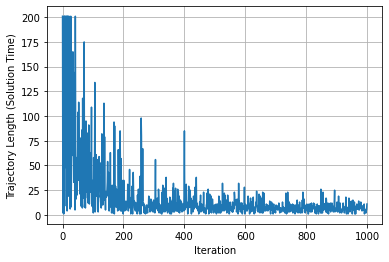

In [25]:
plt.plot(trajectory_length_history2)
plt.ylabel('Trajectory Length (Solution Time)')
plt.xlabel('Iteration')
plt.grid()
plt.show()


## mini-batching

In [38]:


def calculate_reinforce_gradient_batched(trajectories, total_rewards, baseline, traj_action_choices, batches, table=None):
    # TODO: fix this.
    # This function is meant to calculate (dL/d Theta), where L=(\sum_t (log(P_t))(R-b).
    # You need to use the functions tf.math.log and tf.reduce_sum in here, plus the multiplication and subtraction operations.
    if table is None:
        table = table_action_probabilities_before_softmax
    with tf.GradientTape() as tape:
        tape.watch(table)
        b_traj_action_probabilities = []
        b_chosen_probs = []
        b_total_rewards = []
        for t in range(batches):

            b_traj_action_probabilities.append(get_action_probabilities_for_trajectory(trajectories[t], table))
            #b_chosen_probs.append(tf.gather(b_traj_action_probabilities[t], indices=traj_action_choices[t], axis=1, batch_dims=1))
        #b_traj_action_probabilities = tf.stack(b_traj_action_probabilities, axis=0)
        print(b_traj_action_probabilities)
        #trajectory_action_probabilities=get_action_probabilities_for_trajectory(trajectory, table) # this returns a tensor of shape [trajectory_length,4]
        chosen_probabilities=tf.gather(b_traj_action_probabilities, indices=traj_action_choices, axis=1, batch_dims=batches) # this returns a tensor of shape [trajectory_length]
        L = tf.reduce_sum(tf.math.log(chosen_probabilities)) * (np.average(total_rewards) - baseline)
        #L=0 # TODO fix this line of code!
    assert len(L.shape)==0 # checking the original large array has gone through a reduce_sum
    grads = tape.gradient(L, table) # This calculates the gradient required by REINFORCE
    # This function doesn't actually do the update.  It just calculates the gradient ascent direction, and returns it!
    return grads

table_action_probabilities_before_softmax3=tf.Variable(np.zeros((maze_height,maze_width,len(action_names)),np.float32),tf.float32)

iterations3 = 1000
discount_factor3=0.95
reward_history3=[]
trajectory_length_history3=[]
batch_size3 = 5

random_starts3: bool = True
random_starts_in_batch: bool = True

optimizer3=keras.optimizers.Adam(0.1)
iter_count = 0
for iteration in range(0, iterations3, batch_size3):
    if random_starts3:
        b_start_state=get_random_maze_item()
    else:
        b_start_state = start_state
    total_reward=0
    done=False
    time_step=0
    trajectory=[]
    step_rewards=[]
    action_choices=[]
    b_lengths = []
    b_actions = []
    b_rewards = []
    b_choices = []
    b_totals = []
    b_trajectories = []

    baseline=0
    #if iteration > 1:
    #    baseline = reward_history3[iteration//batch_size3-1]
    if iter_count >= 20:
        baseline = np.average(reward_history3[iter_count-20:iter_count])

    batch_grads = []
    for t in range(batch_size3):
        done = False
        t_rewards = []
        t_actions = []
        t_states = []
        t_trajectory = []
        t_total = 0
        if random_starts_in_batch:
            state = get_random_maze_item()
        else:
            state = b_start_state
        while not done:
            action = run_stochastic_policy(state, table_action_probabilities_before_softmax3)
            t_trajectory.append(np.array(state, np.int32))
            #print("time_step",time_step,"state",state,"action",action)
            next_state, reward, done = environment_step(action, state)
            #t_actions[state] = action
            #t_rewards[state] = reward
            t_actions.append(action)
            t_rewards.append(reward)
            t_states.append(state)

            state = next_state
            t_total += reward*(discount_factor3**time_step)
            time_step+=1
            if time_step>200:
                # break trajectory.  This maze is currently too difficult for REINFORCE to complete a trajectory.
                done=True
        b_lengths.append(time_step)
        t_tot_reward = discount_factor3**(time_step-1)
        b_totals.append(t_tot_reward)
        t_trajectory = np.stack(t_trajectory, axis=0)
        t_actions = np.stack(t_actions, axis=0)
        b_actions.append(t_actions)
        b_rewards.append(t_rewards)
        b_trajectories.append(t_trajectory)


        batch_grads.append(
            calculate_reinforce_gradient(t_trajectory, t_tot_reward, baseline, t_actions, table_action_probabilities_before_softmax3)
        )

    stacked_grads = tf.stack(batch_grads, axis=0)
    grads = tf.reduce_mean(stacked_grads, axis=0)
    #grads = calculate_reinforce_gradient_batched(b_trajectories, b_totals, baseline, b_actions, batch_size3, table_action_probabilities_before_softmax3)
    optimizer3.apply_gradients(zip([-grads], [table_action_probabilities_before_softmax3])) # This updates the parameter vector.  Note the minus sign here (because tensorflow optimize functions assume you only ever want graident DESCENT, but we want ascent here)

    trajectory_length = np.average(b_lengths) #sum(b_lengths)/len(b_lengths)
    total_reward = np.average(b_totals) #sum(b_totals)/len(b_totals)

    trajectory_length_history3.append(trajectory_length)
    reward_history3.append(total_reward)
    iter_count += 1
    print("Iteration",iteration,"total_reward",total_reward, "trajectory_length",trajectory_length, "baseline", baseline)


Iteration 0 total_reward 0.0003183537649152755 trajectory_length 170.0 baseline 0
Iteration 5 total_reward 3.1718325187741674e-05 trajectory_length 203.0 baseline 0
Iteration 10 total_reward 0.02116500928062383 trajectory_length 155.6 baseline 0
Iteration 15 total_reward 0.17150100820203992 trajectory_length 162.8 baseline 0
Iteration 20 total_reward 0.016882580227983255 trajectory_length 132.6 baseline 0
Iteration 25 total_reward 0.004366356679465361 trajectory_length 124.6 baseline 0
Iteration 30 total_reward 0.006810870129398161 trajectory_length 138.0 baseline 0
Iteration 35 total_reward 0.011201529857138733 trajectory_length 128.0 baseline 0
Iteration 40 total_reward 0.04388814087071252 trajectory_length 139.2 baseline 0
Iteration 45 total_reward 5.401179204674465e-05 trajectory_length 196.8 baseline 0
Iteration 50 total_reward 0.030403802019053905 trajectory_length 142.8 baseline 0
Iteration 55 total_reward 9.089893541318873e-05 trajectory_length 189.6 baseline 0
Iteration 60 tot

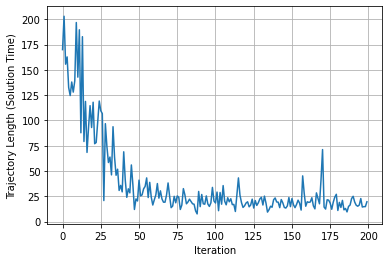

In [39]:
plt.plot(trajectory_length_history3)
plt.ylabel('Trajectory Length (Solution Time)')
plt.xlabel('Iteration')
plt.grid()
plt.show()